# Quantum simulation including noise on the hardware

In [1]:
# Python Libraries
import numpy as np
from numpy import linalg
from numpy import pi
import scipy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import time

import datetime
from typing import Optional, List


# qiskit

from qiskit import QuantumCircuit
from qiskit_aer import QasmSimulator, UnitarySimulator, StatevectorSimulator
from qiskit.quantum_info import Pauli
X = Pauli('X')
Y = Pauli('Y')
Z = Pauli('Z')
I = Pauli('I')
#from qiskit.utils import QuantumInstance, algorithm_globals
#from qiskit.algorithms import VQE
#from qiskit.algorithms.optimizers import SLSQP, SPSA, COBYLA
from qiskit.circuit.library import TwoLocal, NLocal
from qiskit.circuit import ParameterVector, QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Session
#from qiskit.quantum_info.operators import Operator, Pauli
#from qiskit.quantum_info import process_fidelity
#from qiskit.opflow import PauliExpectation
#from qiskit.transpiler import CouplingMap

# Import from Qiskit Aer noise module
#from qiskit.providers.models import BackendProperties
#from qiskit.providers.aer import noise
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error

#######
from qiskit.result.mitigation.utils import (
    expval_with_stddev,
    str2diag,
    counts_probability_vector
)
import os
#from qiskit.providers.aer.noise import NoiseModel

from qiskit.transpiler import CouplingMap
          
print('Import successful')

Import successful


# Transverse-field Ising model
### $\mathcal{H} = b (s_{x1}+s_{x2}) + J s_{z1}s_{z2} = \frac{b}{2} (X_1 + X_2) + \frac{J}{4} Z_1 Z_2 $

## Suzuki-Trotter decomposition

In [60]:
b = 1;
J = 2;
Ntime = 100; 
Ntr = 10;

H1 = b*(X.tensor(I).to_matrix() + I.tensor(X).to_matrix())/2;
H2 = J*Z.tensor(Z).to_matrix()/4;
Ham = H1 + H2;

Mz = (Z.tensor(I).to_matrix()+I.tensor(Z).to_matrix())/2

time = np.linspace(0,4*pi,Ntime)

psi0 = np.array([1,0,0,0])

Mzt = []
Mzt_T = []

for it in range(Ntime):
    
    psi = np.dot(scipy.linalg.expm(-Ham*time[it]*1j),psi0)
    Mzt.append( np.real(np.dot(np.conj(psi),np.dot(Mz,psi))))
    
    exp1 = scipy.linalg.expm(-H1*time[it]*1j/Ntr);
    exp2 = scipy.linalg.expm(-H2*time[it]*1j/Ntr);
    
    psi_T = np.dot(np.linalg.matrix_power(np.dot(exp1,exp2),Ntr),psi0)
    Mzt_T.append(np.real( np.dot(np.conj(psi_T),np.dot(Mz,psi_T))))


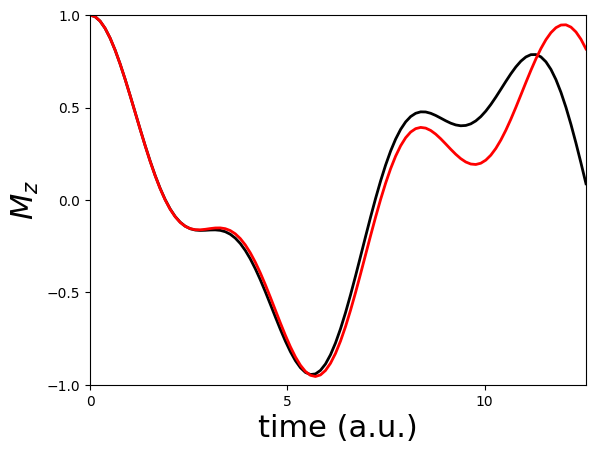

In [3]:
# plot results

fig, ax = plt.subplots()

plt.plot(time, Mzt, linewidth=2.0, color = 'k')
plt.rc('xtick', labelsize=24)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("time (a.u.)",size=22)
plt.ylabel("$M_z$",size=22)

plt.ylim([-1,1])
plt.xlim([0,4*pi])

plt.plot(time, Mzt_T, linewidth=2.0, color = 'r')

In [4]:
service = QiskitRuntimeService(channel='ibm_quantum',token='a67cbd727256bbab2306b1857d9a0fcbc82dc599a32a20157a0be3e76894a4a8860a4c69252121fbb7f03d9caca6f126661885cddbc21c0bc39a5eb3cf62220d')
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyiv')>,
 <IBMBackend('ibm_oslo')>,
 <IBMBackend('ibm_sherbrooke')>]

# Noise model

In [57]:
NS ='noisy_hardware' # noiseless, 'noisy_hardware', 'noisy_custom', 'noisy_relax'
HW = 'ibm_brisbane'


if NS == "noiseless":
    print('Noiseless simulation')
    
elif NS == "noisy_hardware":
        
    device_backend  = service.backend(HW) 
    noise_model = NoiseModel.from_backend(device_backend )
    coupling_map = device_backend.configuration().coupling_map
    basis_gates = device_backend.configuration().basis_gates

elif NS == "noisy_custom":
    ###### Build a custom noise model ##########
    # https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html

    ### Create an empty noise model
    noise_model = NoiseModel()

    # Add reset bit flip error to all qubit 
    p_reset = 0.0
    error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
    noise_model.add_all_qubit_quantum_error(error_reset, "reset")

    # Add depolarizing error to all single qubit u1, u2, u3 gates
    error_dp = depolarizing_error(0.001, 1) # pauli_error(['Z',p_z],('I',1-p_z)) 
    noise_model.add_all_qubit_quantum_error(error_dp, ['u1','u2','u3'])

#    p_z = 0.001
#    error_1q = pauli_error(['Z',p_z],('I',1-p_z))
            
     # Add depolarizing error to all two-qubit cx gates
    error_dp = depolarizing_error(0.01, 2)
    noise_model.add_all_qubit_quantum_error(error_dp, ['cx'])


    # Add single-qubit errors to each qubit when perform 2-qubit gate 
    p_gate1 = 0.0
    error1 = pauli_error([('X', p_gate1), ('I', 1 - p_gate1)])
    error_cx = error1.tensor(error1)
    noise_model.add_all_qubit_quantum_error(error_cx, ["cx"])

    # Measurement mis-assignement probabilities
    p0given1 = 0.05
    p1given0 = 0.03
    error_readout = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])
    noise_model.add_all_qubit_readout_error(error_readout)


    coupling_map = CouplingMap.from_full(2) # Return a fully connected coupling map on n qubits.
    # Other options: from_line, from_ring, from_grid
    # Ref: https://qiskit.org/documentation/stubs/qiskit.transpiler.CouplingMap.html

    basis_gates = ['u1','u2','u3','cx']
    
elif NS == "noisy_relax":
    
    ### Create an empty noise model
    noise_model = NoiseModel() 
    
    # T1 and T2 values for qubits 0-3
    T1s = 30e3  #  30 microsec
    T2s = 30e3  #  30 microsec

    # Instruction times (in nanoseconds)
    time_u1 = 0   # virtual gate
    time_u2 = 50  # (single X90 pulse)
    time_u3 = 100 # (two X90 pulses)
    time_cx = 500
    time_reset = 1000  # 1 microsecond
    time_measure = 1000 # 1 microsecond

    # QuantumError objects
    errors_reset = thermal_relaxation_error(T1s, T2s, time_reset)
    errors_measure = thermal_relaxation_error(T1s, T2s, time_measure)
    errors_u2 = thermal_relaxation_error(T1s, T2s, time_u2)
    errors_u3 = thermal_relaxation_error(T1s, T2s, time_u3)
    errors_cx = thermal_relaxation_error(T1s, T2s, time_cx).expand(\
                 thermal_relaxation_error(T1s, T2s, time_cx))
    # Add errors to noise model
    #noise_thermal = NoiseModel()

    noise_model.add_all_qubit_quantum_error(errors_reset, "reset")
    noise_model.add_all_qubit_quantum_error(errors_u2, "u2")
    noise_model.add_all_qubit_quantum_error(errors_u3, "u3")
    noise_model.add_all_qubit_quantum_error(errors_cx, "cx")
    noise_model.add_all_qubit_quantum_error(errors_measure, "readout")
    
    coupling_map = CouplingMap.from_full(2) 
    basis_gates = ['u1','u2','u3','cx']


### Gate decomposition

##### one-body ($X_{1,2}$) terms correspond to Rx single qubit rotations
##### two-body ZZ term can be simulated by CX, Rz(2phi), CX

In [61]:
time_sim = np.linspace(0, 4*pi, 20)

Nshots = 8192

backend = QasmSimulator()

Mz_sim = []
for it in range(len(time_sim)):
    
    qc = QuantumCircuit(2,2)
    
    for itr in range(Ntr):
        
        qc.rx(b*time_sim[it]/Ntr,0)
        qc.barrier()
        qc.rx(b*time_sim[it]/Ntr,1)
        
        qc.cx(0,1)
        qc.barrier()
        qc.rz(2*J*time_sim[it]/Ntr/4,1)
        qc.barrier()
        qc.cx(0,1)
        
    qc.measure(0,0)
    qc.measure(1,1)

    if NS == "noiseless":
        results = backend.run(qc, shots=Nshots).result()
    else:
        results = backend.run(qc, shots=Nshots, noise_model = noise_model,\
                          basis_gates = basis_gates, coupling_map = coupling_map).result() 
    
    counts = results.get_counts()
    
    if not "00" in counts: counts["00"] = 0
    if not "01" in counts: counts["01"] = 0
    if not "10" in counts: counts["10"] = 0
    if not "11" in counts: counts["11"] = 0
        
    Mz_sim.append( (counts['00']-counts['11'])/Nshots )

In [44]:
print(noise_model)

NoiseModel:
  Basis gates: ['delay', 'ecr', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['reset', 'measure', 'x', 'id', 'sx', 'ecr']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('id', (4,)), ('id', (5,)), ('id', (6,)), ('id', (7,)), ('id', (8,)), ('id', (9,)), ('id', (10,)), ('id', (11,)), ('id', (12,)), ('id', (13,)), ('id', (14,)), ('id', (15,)), 

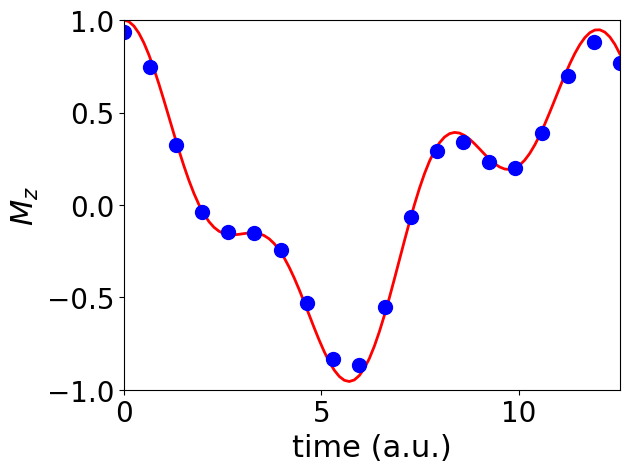

In [62]:
# plot results

fig, ax = plt.subplots()

#plt.plot(time, Mzt, linewidth=2.0, color = 'k')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("time (a.u.)",size=22)
plt.ylabel("$M_z$",size=22)

plt.ylim([-1,1])
plt.xlim([0,4*pi])

plt.plot(time, Mzt_T, linewidth=2.0, color = 'r')

plt.plot(time_sim, Mz_sim, color='b', lw=0, marker='o', markersize=10)


In [8]:
print(Mz_sim[9])
print(Mzt_T[47])

#print(time_sim[9])
#print(time[47])

print((Mz_sim[9]-Mzt_T[47])/np.abs(Mzt_T[47]))

Mz_sim[0]

-0.866943359375
-0.9230850590274184
0.06081963856242078


0.93798828125

## Targeted error mitigation 

#### Apply general properties of the target model to mitigate (readout) errors

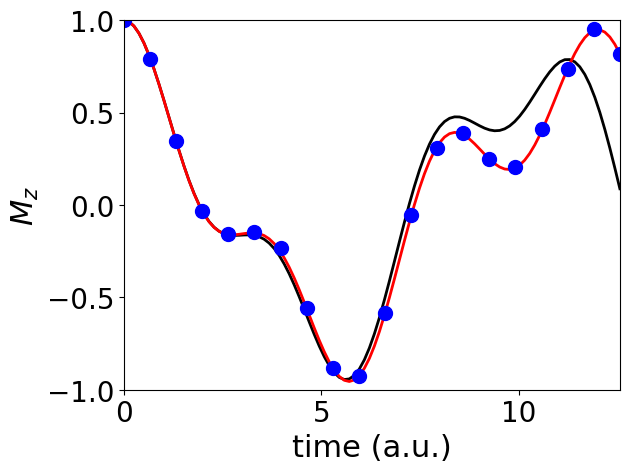

In [9]:
scale_factor = 1/Mz_sim[0]

# plot error-mitigated results

fig, ax = plt.subplots()

plt.plot(time, Mzt, linewidth=2.0, color = 'k')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("time (a.u.)",size=22)
plt.ylabel("$M_z$",size=22)

plt.ylim([-1,1])
plt.xlim([0,4*pi])

plt.plot(time, Mzt_T, linewidth=2.0, color = 'r')

plt.plot(time_sim, np.array(Mz_sim)*scale_factor, color='b', lw=0, marker='o', markersize=10)

In [10]:
print(Mz_sim[9]*scale_factor)

(Mz_sim[9]*scale_factor-Mzt_T[47])/np.abs(Mzt_T[47])

-0.9242581988547631


-0.0012708902780646531

## Measurement error mitigation

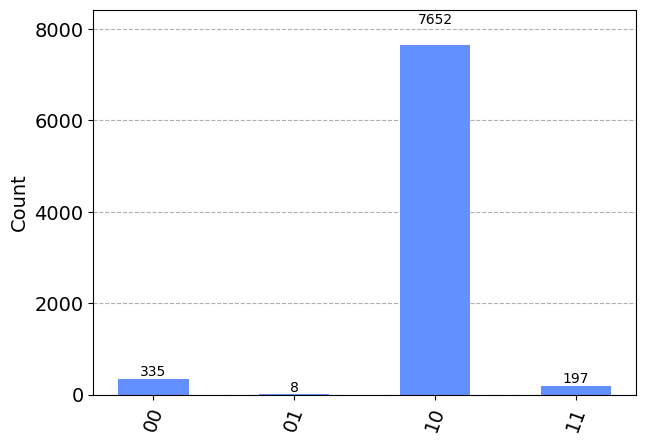

In [63]:
from qiskit.visualization import plot_histogram 

qc_mem = QuantumCircuit(2,2)

#qc_mem.x(0)
qc_mem.x(1)

qc_mem.measure(0,0)
qc_mem.measure(1,1)

results = backend.run(qc_mem, shots=Nshots, noise_model = noise_model,\
                          basis_gates = basis_gates, coupling_map = coupling_map).result() 

counts = results.get_counts()

plot_histogram(counts)

In [64]:
np.round([counts["00"]/Nshots, counts["01"]/Nshots, counts["10"]/Nshots, counts["11"]/Nshots],3)

array([0.041, 0.001, 0.934, 0.024])

## Measurement error mitigation

In [63]:
from qiskit import QuantumCircuit
from qiskit.visualization import plot_distribution
from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError
from qiskit_aer import AerSimulator

exp = LocalReadoutError([0,1])
for c in exp.circuits():
    print(c)

         ░ ┌─┐   
   q_0: ─░─┤M├───
         ░ └╥┘┌─┐
   q_1: ─░──╫─┤M├
         ░  ║ └╥┘
meas: 2/════╩══╩═
            0  1 
        ┌───┐ ░ ┌─┐   
   q_0: ┤ X ├─░─┤M├───
        ├───┤ ░ └╥┘┌─┐
   q_1: ┤ X ├─░──╫─┤M├
        └───┘ ░  ║ └╥┘
meas: 2/═════════╩══╩═
                 0  1 


In [64]:
exp.analysis.set_options(plot=True)
backend = AerSimulator.from_backend(service.backend(HW))

result = exp.run(backend, noise_model = noise_model, basis_gates = basis_gates, coupling_map = coupling_map)

mitigator = result.analysis_results("Local Readout Mitigator").value

C:\Users\aless\AppData\Local\Temp\ipykernel_12696\187037153.py:2: DeprecationWarning: The class ``qiskit.providers.models.backendconfiguration.QasmBackendConfiguration`` is deprecated as of qiskit 1.2. It will be removed in the 2.0 release. The models in ``qiskit.providers.models`` are part of the deprecated `BackendV1` workflow and no longer necessary for `BackendV2`. If a user workflow requires these representations it likely relies on deprecated functionality and should be updated to use `BackendV2`.
  backend = AerSimulator.from_backend(service.backend(HW))
C:\Users\aless\anaconda3\envs\qiskit_v1p0\Lib\site-packages\qiskit_ibm_runtime\fake_provider\local_service.py:233: UserWarning: Options {'execution': {'meas_type': 'classified'}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


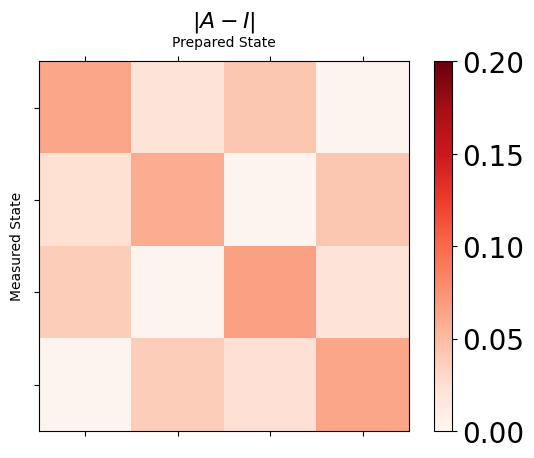

In [65]:
result.figure(0)

In [66]:
for m in mitigator._mitigation_mats:
    print(m)
    print()

[[ 1.02556237 -0.02147239]
 [-0.02556237  1.02147239]]

[[ 1.04255319 -0.04680851]
 [-0.04255319  1.04680851]]



In [74]:
corr = np.linalg.matrix_power(mitigator.assignment_matrix([0,1]),-1)

array([[ 1.06920332e+00, -2.23861115e-02, -4.80050472e-02,
         1.00509072e-03],
       [-2.66501327e-02,  1.06493930e+00,  1.19653657e-03,
        -4.78136014e-02],
       [-4.36409520e-02,  9.13718836e-04,  1.07356742e+00,
        -2.24774834e-02],
       [ 1.08776052e-03, -4.34669103e-02, -2.67589088e-02,
         1.06928599e+00]])

In [84]:
vcounts = [counts['00'], counts['01'], counts['10'], counts['11']];
display(vcounts)
np.dot(corr,vcounts)

[6401, 783, 879, 129]

array([6784.3753731 ,  658.14377583,  662.13587434,   87.34497672])

### Apply measurement error mitigation to the results

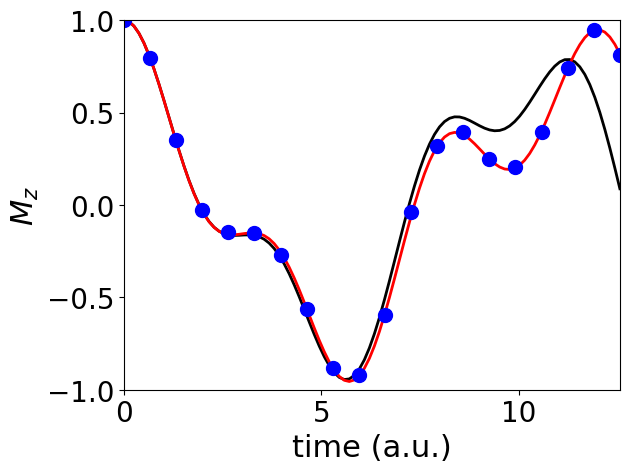

In [87]:

Mz_sim = []
for it in range(len(time_sim)):
    
    qc = QuantumCircuit(2,2)
    
    for itr in range(Ntr):
        
        qc.rx(b*time_sim[it]/Ntr,0)
        qc.rx(b*time_sim[it]/Ntr,1)
        
        qc.cx(0,1)
        qc.rz(2*J*time_sim[it]/Ntr/4,1)
        qc.cx(0,1)
        
    qc.measure(0,0)
    qc.measure(1,1)

    results = backend.run(qc, shots=Nshots, noise_model = noise_model,\
                          basis_gates = basis_gates, coupling_map = coupling_map, method="density_matrix").result() 
    unmitigated_counts = results.get_counts()

    vcounts = [unmitigated_counts['00'], unmitigated_counts['01'], unmitigated_counts['10'], unmitigated_counts['11']];
    mitigated_counts = np.dot(corr,vcounts)

    Mz_sim.append( (mitigated_counts[0]-mitigated_counts[3])/Nshots )
        
# plot error-mitigated results

fig, ax = plt.subplots()

plt.plot(time, Mzt, linewidth=2.0, color = 'k')
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("time (a.u.)",size=22)
plt.ylabel("$M_z$",size=22)

plt.ylim([-1,1])
plt.xlim([0,4*pi])

plt.plot(time, Mzt_T, linewidth=2.0, color = 'r')

plt.plot(time_sim, Mz_sim, color='b', lw=0, marker='o', markersize=10)

In [33]:
Mz_sim[9]

-0.8863941814836859

### Zero-noise extrapolation (CNOTS)

In [ ]:
time_sim

In [51]:
Mz_sim_cx = []
       
Ncx = [1, 3, 5, 7, 9] 
Ntr = 5
for incx in Ncx: 
    
    qc = QuantumCircuit(2,2)
    for itr in range(Ntr):
        
        qc.rx(b*time_sim[9]/Ntr,0)
        qc.rx(b*time_sim[9]/Ntr,1)
        
        qc.cx(0,1)
        qc.rz(2*J*time_sim[9]/Ntr/4,1)
    
        for icx in range(incx):
            qc.cx(0,1)
            qc.barrier()
            
    qc.measure(0,0)
    qc.measure(1,1)

    results = backend.run(qc, shots=Nshots, noise_model = noise_model,\
                          basis_gates = basis_gates, coupling_map = coupling_map).result() 
    
    counts = results.get_counts()
    
    if not "00" in counts: counts["00"] = 0
    if not "01" in counts: counts["01"] = 0
    if not "10" in counts: counts["10"] = 0
    if not "11" in counts: counts["11"] = 0
        
    Mz_sim_cx.append( (counts['00']-counts['11'])/Nshots )

In [52]:
Mz_sim_cx

[-0.804443359375,
 -0.72216796875,
 -0.64404296875,
 -0.5943603515625,
 -0.529052734375]

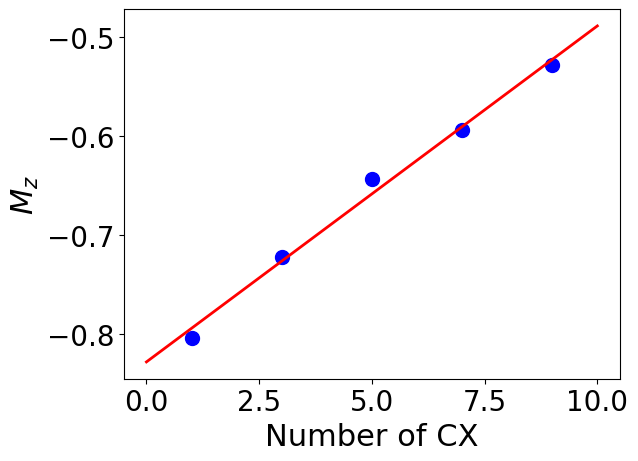

In [53]:
# plot error-mitigated results

fig, ax = plt.subplots()

plt.plot(Ncx, Mz_sim_cx, color='b', lw=0, marker='o', markersize=10)
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels      
plt.xlabel("Number of CX",size=22)
plt.ylabel("$M_z$",size=22)

#plt.ylim([-1,-0.5])
#plt.xlim([0,10])

p = np.polyfit(Ncx, Mz_sim_cx, 1)

x = np.linspace(0,10,10)
plt.plot(x,np.polyval(p,x), linewidth=2.0, color = 'r')


In [54]:
print(p[0]) # 
print(p[1]) # Intercept  --> Zero noise solution  

0.03392944335937495
-0.8284606933593744


In [55]:
time[47]

5.96585271590789

In [56]:
Mzt_T[47]

-0.9230850590274184